In [1]:
import os
import numpy as np
import pandas as pd
import compress_json
from glob import glob
from typing import Dict
import matplotlib.pyplot as plt
from humanize import naturaldelta
from tqdm.auto import tqdm, trange
from time import perf_counter, sleep
from sanitize_ml_labels import sanitize_ml_labels

# Load the data

In [2]:
files = glob('./graphs/results/**/*.csv', recursive=True)
files

['./graphs/results/bn-macaque-rhesus-brain-1/Node2Vec/execute_second_order_walks.csv',
 './graphs/results/bn-macaque-rhesus-brain-1/Node2Vec/execute_first_order_walks.csv',
 './graphs/results/bn-macaque-rhesus-brain-1/EnsmallenGraph/load_graph.csv',
 './graphs/results/bn-macaque-rhesus-brain-1/EnsmallenGraph/execute_second_order_walks.csv',
 './graphs/results/bn-macaque-rhesus-brain-1/EnsmallenGraph/execute_first_order_walks.csv',
 './graphs/results/bn-macaque-rhesus-brain-1/Networkx/load_graph.csv',
 './graphs/results/bn-macaque-rhesus-brain-1/iGraph/load_graph.csv',
 './graphs/results/bn-macaque-rhesus-brain-1/CSRgraph/load_graph.csv',
 './graphs/results/bn-macaque-rhesus-brain-1/CSRgraph/execute_second_order_walks.csv',
 './graphs/results/bn-macaque-rhesus-brain-1/CSRgraph/execute_first_order_walks.csv',
 './graphs/results/bn-macaque-rhesus-brain-1/GraphEmbedding/execute_second_order_walks.csv',
 './graphs/results/bn-macaque-rhesus-brain-1/GraphEmbedding/execute_first_order_walks.cs

In [3]:
with open('./graphs/results/StringPPI/GraphEmbedding/execute_second_order_walks.csv', "r") as f:
    texts = f.read()

In [4]:
execs_type = {}
result = pd.DataFrame()
for file in files:
    # From the path extract the infos
    *_, graph, library, task = file.split("/")
    # Load the file
    df = pd.read_csv(file, header=None)
    df.columns = ["time", "memory"]
    df["graph"] = graph
    df["library"] = library
    df["task"] = task.split(".")[0]
    
    # Check if the experiment was killed
    last_row = df.iloc[-1]
    if last_row.time == -1 and last_row.memory == -1:
        exec_type = "exception"
    elif last_row.time == 0 and last_row.memory == 0:
        exec_type = "ok"
    else:
        exec_type = "killed"
        
    execs_type.setdefault(graph, {})
    execs_type[graph].setdefault(library, {})
    execs_type[graph][library][task.split(".")[0]] = exec_type
    
    # Remove the not killed flag (last line)
    if exec_type != "killed" :
        df = df.drop(df.tail(1).index)
    
    # Update the global results
    result = pd.concat([result, df])

result

,time,memory,graph,library,task
0,0.000000,0.002709,bn-macaque-rhesus-brain-1,Node2Vec,execute_second_order_walks
1,0.000145,0.003189,bn-macaque-rhesus-brain-1,Node2Vec,execute_second_order_walks
2,0.000274,0.003189,bn-macaque-rhesus-brain-1,Node2Vec,execute_second_order_walks
3,0.000367,0.003189,bn-macaque-rhesus-brain-1,Node2Vec,execute_second_order_walks
4,0.000454,0.003189,bn-macaque-rhesus-brain-1,Node2Vec,execute_second_order_walks
...,...,...,...,...,...
969,6665.110474,163.068909,StringPPI,GraphEmbedding,execute_first_order_walks
970,6845.210995,167.149529,StringPPI,GraphEmbedding,execute_first_order_walks
971,7025.311698,86.083996,StringPPI,GraphEmbedding,execute_first_order_walks
972,7205.412248,32.882771,StringPPI,GraphEmbedding,execute_first_order_walks


In [5]:
execs_type

{'bn-macaque-rhesus-brain-1': {'Node2Vec': {'execute_second_order_walks': 'ok',
   'execute_first_order_walks': 'ok'},
  'EnsmallenGraph': {'load_graph': 'ok',
   'execute_second_order_walks': 'ok',
   'execute_first_order_walks': 'ok'},
  'Networkx': {'load_graph': 'ok'},
  'iGraph': {'load_graph': 'ok'},
  'CSRgraph': {'load_graph': 'ok',
   'execute_second_order_walks': 'ok',
   'execute_first_order_walks': 'ok'},
  'GraphEmbedding': {'execute_second_order_walks': 'ok',
   'execute_first_order_walks': 'ok'}},
 'StringPPI': {'Node2Vec': {'execute_second_order_walks': 'ok',
   'execute_first_order_walks': 'ok'},
  'EnsmallenGraph': {'load_graph': 'ok',
   'execute_second_order_walks': 'ok',
   'execute_first_order_walks': 'ok'},
  'Networkx': {'load_graph': 'ok'},
  'iGraph': {'load_graph': 'ok'},
  'CSRgraph': {'load_graph': 'ok',
   'execute_second_order_walks': 'ok',
   'execute_first_order_walks': 'ok'},
  'GraphEmbedding': {'execute_second_order_walks': 'exception',
   'execute_f

### Plot RAM over time for each task and each graph

In [6]:
def legend_without_duplicate_labels(fig, axes, **kwargs):
    labels_set = set()
    uniques = []
    for row in axes:
        for ax in row:
            handles, labels = ax.get_legend_handles_labels()
            axis_unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            for (h, l) in axis_unique:
                if l not in labels_set:
                    labels_set.add(l)
                    uniques.append((h, l))
    ax.legend(*zip(*uniques), **kwargs)

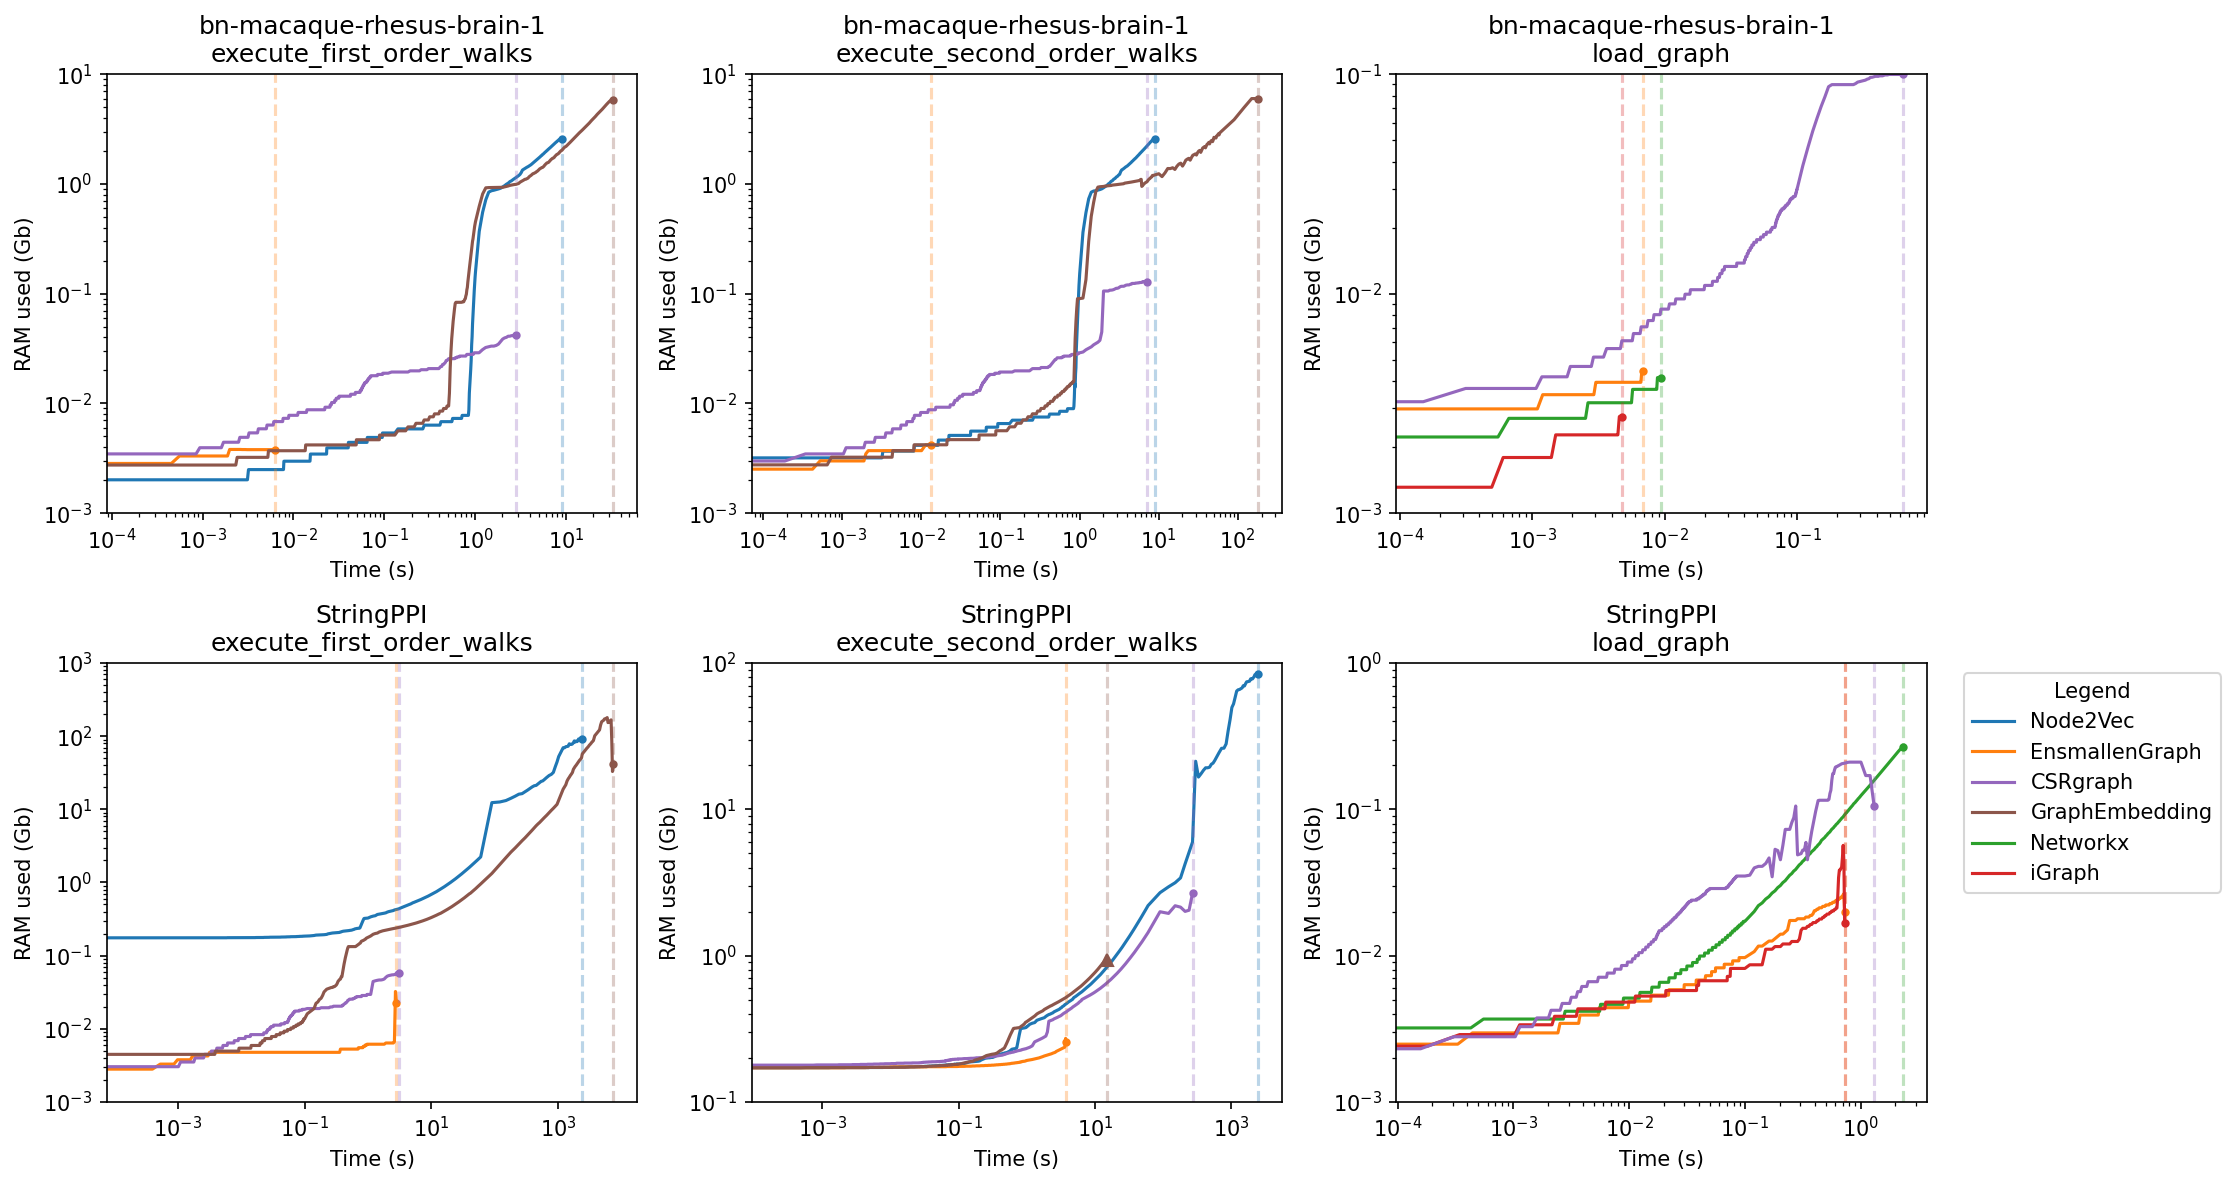

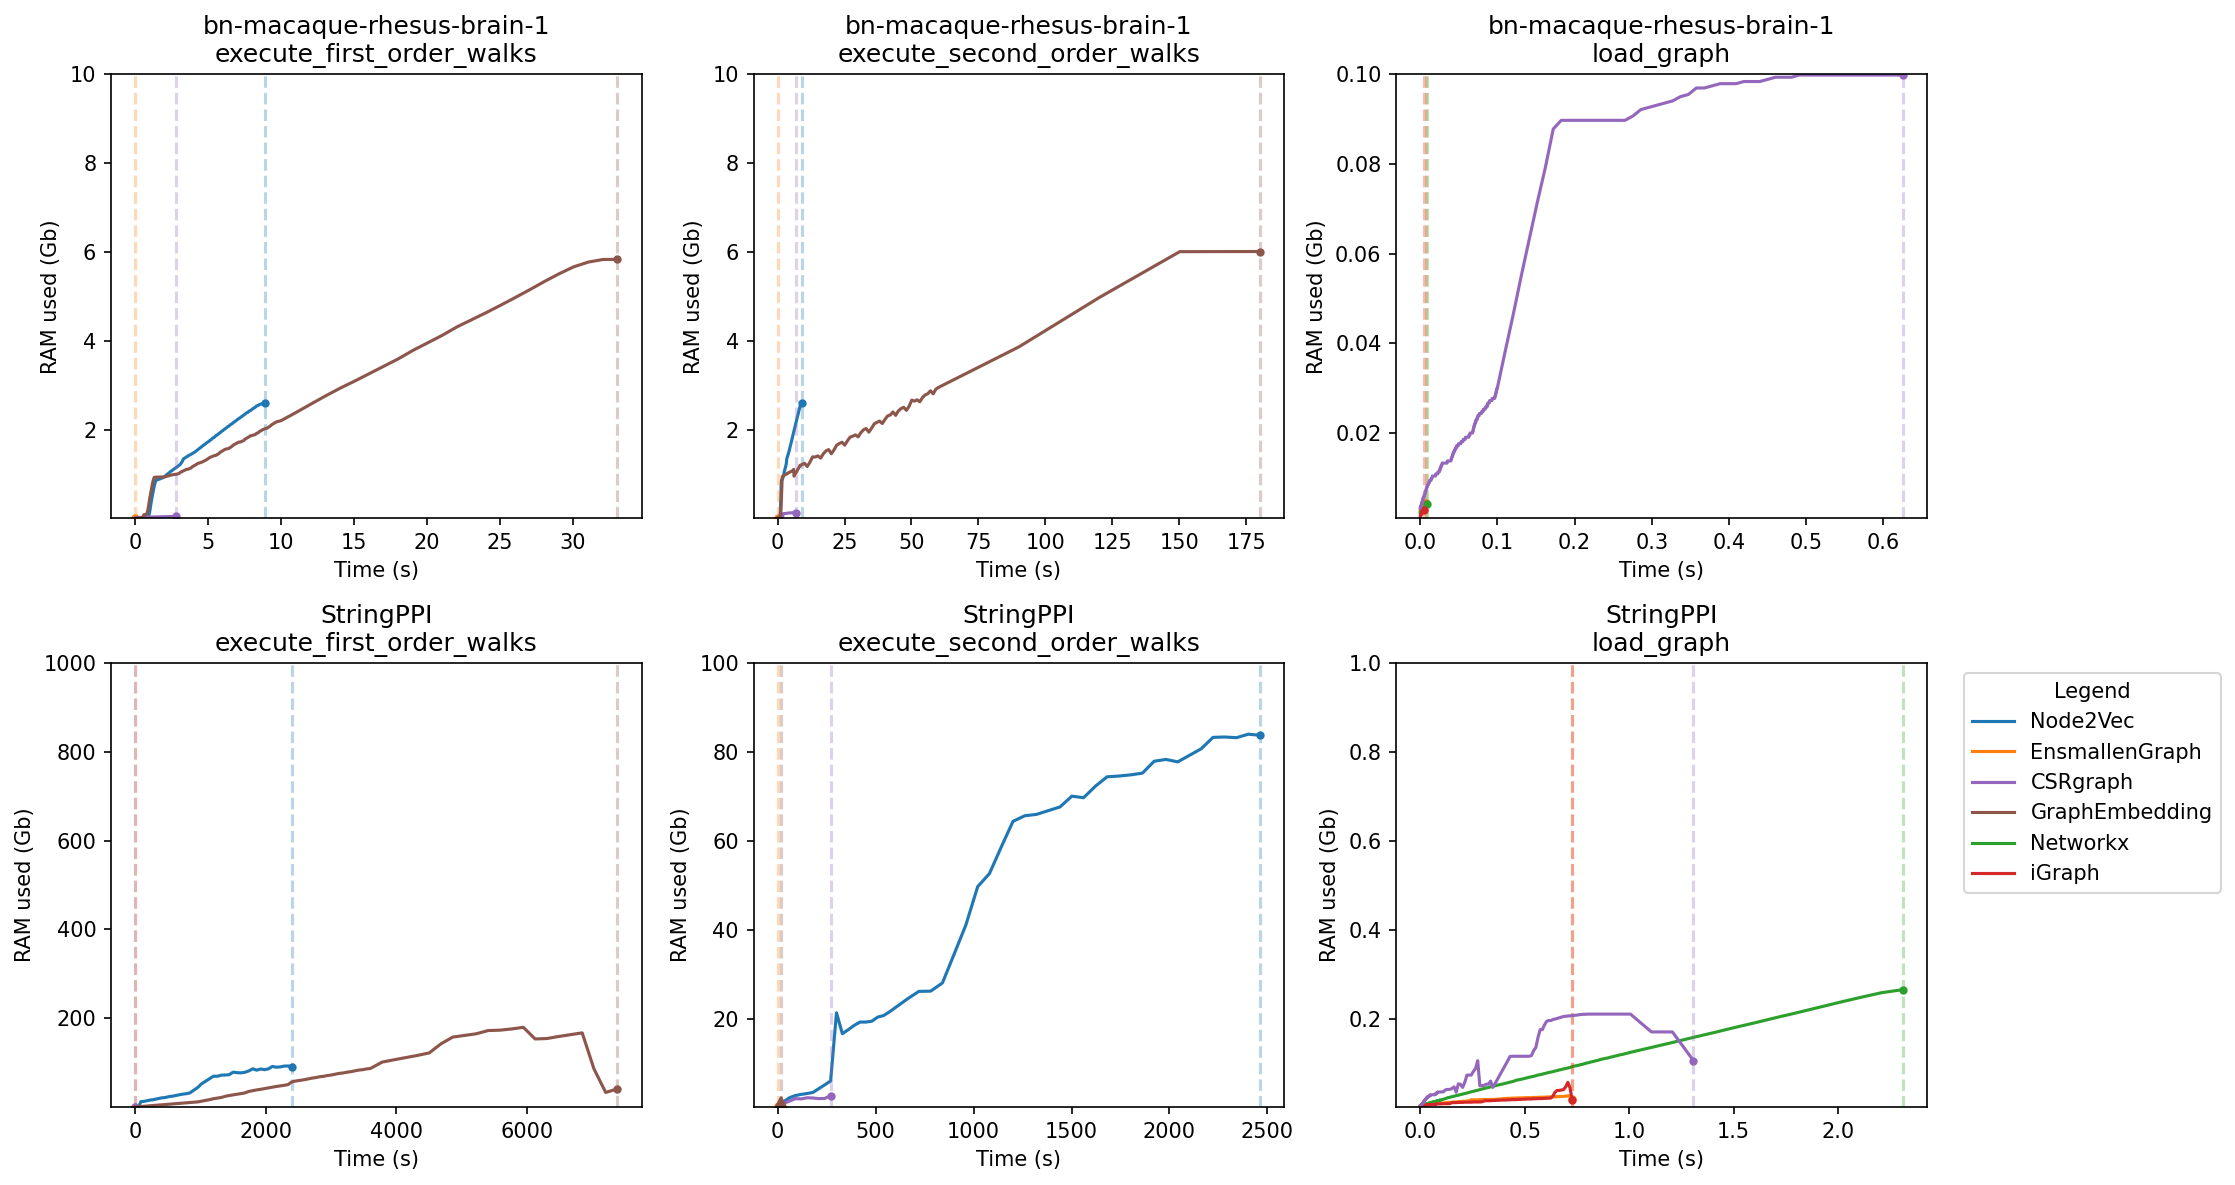

In [7]:
cmap = plt.get_cmap("tab10")
colors = dict(list(zip(result.library.unique(), cmap.colors)))
ncols=len(result.task.unique())
nrows=len(result.graph.unique())
    

for log in [True, False]:
    fig, axes = plt.subplots(
        dpi=150,
        ncols=ncols,
        nrows=nrows,
        squeeze=False,
        figsize=(5*ncols, 4*nrows)
    )
    for graph, sub_axes in zip(result.graph.unique(), axes):
        for task, axis in zip(sorted(result.task.unique()), sub_axes):
            all_data = result[(result.graph==graph) & (result.task==task)]
            max_y = 10**np.ceil(np.log10(all_data.memory.max()))
            min_y = 10**np.floor(np.log10(all_data.memory.min()))
            for library in result.library.unique():
                # get the data for this triple (graph, task, library)
                filtered = all_data[(all_data.library==library)]
                if len(filtered):
                    # Plot the graph
                    axis.plot(filtered.time, filtered.memory, label=sanitize_ml_labels(library), c=colors[library])
                    x, y = filtered.time.iloc[-1], filtered.memory.iloc[-1]
                    # add the termination marker
                    exec_type = execs_type[graph][library][task]
                    if exec_type == "killed":
                        axis.plot([x], [y], marker="x", c=colors[library], markersize=10)
                    elif exec_type == "exception":
                        axis.plot([x], [y], marker="^", c=colors[library])
                    else:
                        axis.plot([x], [y], marker=".", c=colors[library])
                    # Draw the finish line
                    axis.plot([x, x], [min_y, max_y], "--", alpha=0.3, c=colors[library])
                    
            if not (np.isnan(min_y) or np.isnan(max_y)):
                axis.set_ylim([min_y, max_y])
            axis.set_xlabel("Time (s)")
            axis.set_ylabel("RAM used (Gb)")
            axis.set_title("{graph}\n{task}".format(**locals()))
            
            if log:
                axis.set_yscale('log')
                axis.set_xscale('log')
    legend_without_duplicate_labels(fig, axes, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.tight_layout()
    fig.set_facecolor('w')